<a href="https://colab.research.google.com/github/rajkumar2004725/topic_modeling_for_customer_data_analysis/blob/main/topic_modelling_using_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:
#load dataset from kaggle
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "Reviews.csv"


df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "snap/amazon-fine-food-reviews",
  file_path,

)



<ipython-input-24-b7b575e9b5e1>:8: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [25]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [26]:

df = df.sample(n=10000, random_state=42)

# Data preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Tokenize
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back to string
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['cleaned_text'] = df['Text'].apply(preprocess_text)


In [27]:

# Using TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])



# Display the topics with their top words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get feature names from TF-IDF vectorizer
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


# Topic Modeling using LDA (Latent Dirichlet Allocation)
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_output = lda_model.fit_transform(tfidf)

print("\nTopics identified by LDA (Latent Dirichlet Allocation):")
# Display top 10 words for each topic
display_topics(lda_model, tfidf_feature_names, 10)

# Alternative approach using NMF (Non-Negative Matrix Factorization)
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_output = nmf_model.fit_transform(tfidf)

# Display NMF topics
print("\nTopics identified by NMF:")
display_topics(nmf_model, tfidf_feature_names, 10)

# Assign dominant topic to each document
def assign_topic(model, document_topic_dist):
    return np.argmax(document_topic_dist, axis=1)

df['lda_topic'] = assign_topic(lda_model, lda_output)
df['nmf_topic'] = assign_topic(nmf_model, nmf_output)



Topics identified by LDA (Latent Dirichlet Allocation):
Topic 1:
bar chocolate like taste br good one product great candy
Topic 2:
love great like treat dog good br sauce taste flavor
Topic 3:
food cat dog product price amazon store love find great
Topic 4:
tea taste drink flavor water like br good great green
Topic 5:
coffee cup flavor like good strong taste roast one kcups

Topics identified by NMF:
Topic 1:
taste product like br great good flavor one love would
Topic 2:
coffee cup strong like roast flavor bold pod good taste
Topic 3:
tea green bag drink taste black cup flavor leaf stash
Topic 4:
dog treat love food chew give get small training toy
Topic 5:
cat food eat dry br chicken one canned year ingredient


In [28]:
tfidf[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 28 stored elements and shape (1, 1000)>

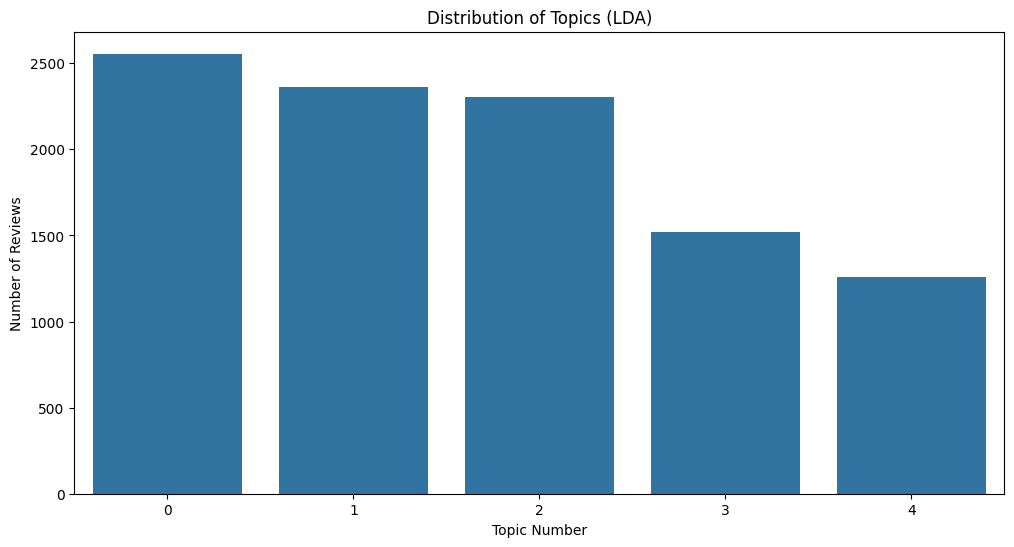

In [29]:

# Visualize the topic distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='lda_topic', data=df)
plt.title('Distribution of Topics (LDA)')
plt.xlabel('Topic Number')
plt.ylabel('Number of Reviews')
plt.show()



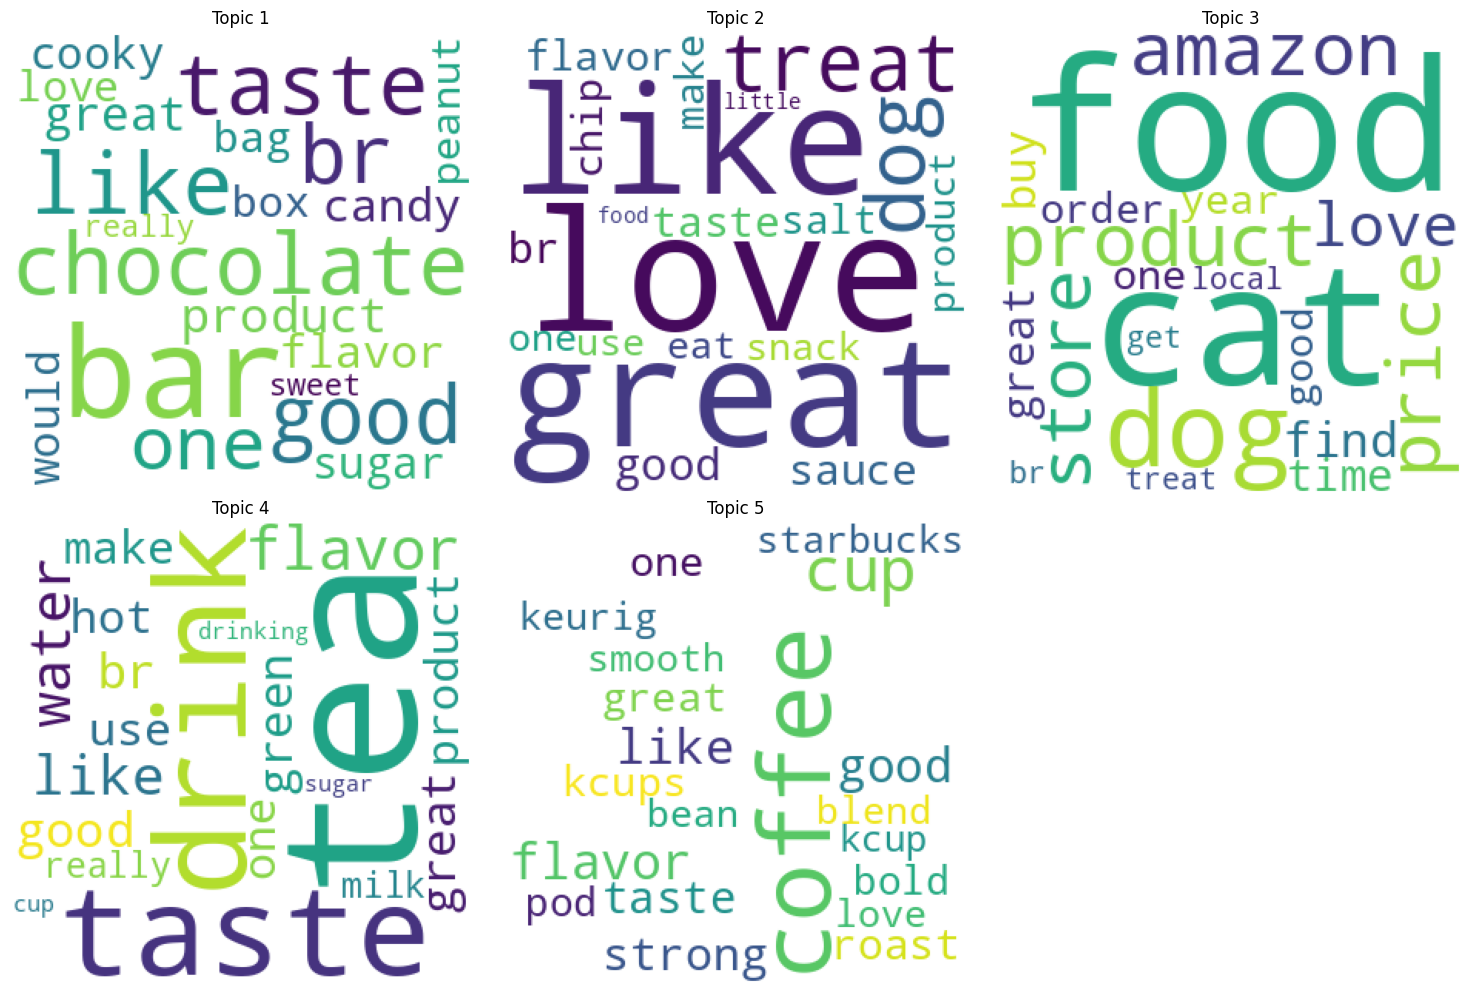

In [34]:
# Create word clouds for each topic
def create_wordclouds(model, feature_names, num_topics, top_words=20):
    plt.figure(figsize=(15, 10))
    for topic_idx in range(num_topics):
        print("\n")
        plt.subplot(2, 3, topic_idx + 1)
        word_weights = model.components_[topic_idx]
        top_word_indices = word_weights.argsort()[:-top_words-1:-1]
        top_words_dict = {feature_names[i]: word_weights[i] for i in top_word_indices}

        wordcloud = WordCloud(width=300, height=300, background_color='white').generate_from_frequencies(top_words_dict)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(f"Topic {topic_idx + 1}")



    plt.tight_layout()
    plt.show()


create_wordclouds(lda_model, tfidf_feature_names, num_topics)



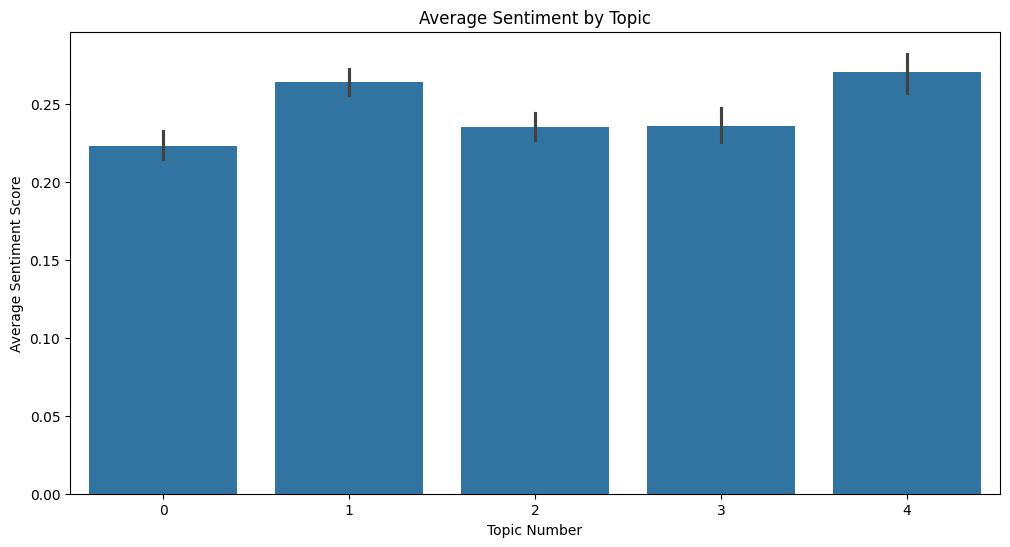

In [35]:
# Analyze sentiment by topic (optional)
from textblob import TextBlob

def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment'] = df['Text'].apply(analyze_sentiment)

# Plot average sentiment by topic
plt.figure(figsize=(12, 6))
sns.barplot(x='lda_topic', y='sentiment', data=df)
plt.title('Average Sentiment by Topic')
plt.xlabel('Topic Number')
plt.ylabel('Average Sentiment Score')
plt.show()

# Save the results with topics assigned
df[['Text', 'cleaned_text', 'lda_topic', 'nmf_topic', 'sentiment']].to_csv('reviews_with_topics.csv', index=False)